In [1]:
!pip install docplex cplex

     |████████████████████████████████| 634 kB 5.0 MB/s 
     |████████████████████████████████| 30.9 MB 1.3 MB/s 
  Created wheel for docplex: filename=docplex-2.22.213-py3-none-any.whl size=696882 sha256=63b5e318d8ccb39352d6bbd22043cc0816012068312b4d63c7034aef58b95dc0
  Stored in directory: /root/.cache/pip/wheels/90/69/6b/1375c68a5b7ff94c40263b151c86f58bd72200bf0c465b5ba3
Successfully built docplex


In [357]:
#Importing cplex API
import sys
import cplex
import docplex.cp

#Importing numpy and random generator
import numpy as np
rand = np.random

#Importing pyplot
import matplotlib.pyplot as plt

#Importing docplex model
from docplex.mp.model import Model
import itertools

#Imports
from enum import Enum
from cplex.callbacks import UserCutCallback, LazyConstraintCallback
from docplex.mp.callbacks.cb_mixin import *
import networkx as nx

**Definizione classi**

Definizione lazy constraints

In [428]:
class LazyCallback(ConstraintCallbackMixin, LazyConstraintCallback):
  def __init__(self, env):
    LazyConstraintCallback.__init__(self, env)
    ConstraintCallbackMixin.__init__(self)

  def __call__(self):
    try:
      # Controlliamo tutti i cicli maggiori di k
      for c in self.C:
        # Salviamo la soluzione trovata senza l'uso di lazy constraints
        y_sol = self.make_complete_solution().get_value_dict(self.y)
        # Controlliamo se il ciclo fa parte della soluzione trovata
        served = sum([y_sol[e] for e in c])

        if not (served <= ((len(c) - 1))):
          print('Adding lazy constraint %s <= %d' % 
                (' + '.join(['y(%d)' % (x) for x in c]), len(c) - 1))
          # Aggiungiamo la matrice con il vincolo relativo al ciclo nel modello
          self.add(constraint=cplex.SparsePair(ind=[x for x in c],
                                               val=[y_sol[e] for e in c]), 
                  sense='L', 
                  rhs=(len(c) - 1))
          
    except:
      print(sys.exc_info()[0])
      raise

Definizione vertice

In [360]:
class Type(Enum):
  AD = 1
  B = 2
  P = 3


class Vertex:
  def __init__(self, tp, delta_in, delta_out):
    self.tp = tp

    # delta_in = minus
    self.delta_in = delta_in
    
    # delta_out = plus
    self.delta_out = delta_out

**Definizione funzioni**

Funzioni di stampa del risultato

In [425]:
def get_edges(y):
  res = []
  for i in y:
    if(y[i] != 0):
      res.append(i)
  
  return set(res)


def get_vertex(f_in, f_out, edges, V):

  V_copy = []
  chains = []
  cycles = []

  # Eliminiamo tutti i vertici non utilizzati nella soluzione
  for i,v in enumerate(V):
    if f_in[i] != 0 or f_out[i] != 0:
      # Calcoliamo l'intersezione tra l'insieme degli edges entranti nel nodo v
      # e l'insieme degli edges usati nella soluzione
      aux_set = edges.intersection(set(v.delta_in))
      # Aggiorniamo la lista degli edges entranti nel nodo v
      v_aux_delta_in = list(aux_set)

      # Calcoliamo l'intersezione tra l'insieme degli edges uscenti dal nodo v
      # e l'insieme degli edges usati nella soluzione
      aux_set = edges.intersection(set(v.delta_out))
      # Aggiorniamo la lista degli edges uscenti dal nodo v
      v_aux_delta_out = list(aux_set)

      # Creiamo una copia del vertice usato nella soluzione trovata
      V_copy.append(Vertex(v.tp, v_aux_delta_in, v_aux_delta_out))

  print(len(V_copy))
  i = 0
  aux = []

  # Controlliamo tutti i vertici della soluzione
  while len(V_copy) > 0:
    
    # Controlliamo se il vertice corrente ha un flusso uscente
    if len(V_copy[i].delta_out) > 0:
      # Salviamo una copia dell'edge uscente dal vertice corrente
      edge_out = V_copy[i].delta_out[0]
      # Aggiungiamo il vertice corrente ad una lista temporanea
      aux.append(V_copy[i])

      vertex_found = False
      # Cerchiamo nella lista il vertice successivo al vertice attuale
      for j,v in enumerate(V_copy):
        if j != i:
          if len(v.delta_in) > 0:

            # Controlliamo se l'edge uscente dal nodo j-esimo è uguale
            # all'edge entrante nel vertice attuale
            if v.delta_in[0] == edge_out:

              # Rimuoviamo il vertice attuale dalla lista dei vertici
              del V_copy[i]
              vertex_found = True
              # Aggiorniamo l'indice del vertice attuale
              i = V_copy.index(v)
              break
      
      # Se non è stato trovato il vertice successivo al vertice attuale,
      # questo è l'utimo vertice di un ciclo
      if not vertex_found:
        cycles.append(aux)
        aux = []
        del V_copy[i]
        i = 0

    # Se il vertice corrente non ha un flusso uscente, questo è l'ultimo vertice
    # di una catena
    else:
      # Controlliamo se il vertice attuale non è il primo della lista temporanea
      if len(aux) > 0:
        aux.append(V_copy[i])
        chains.append(aux)
        aux = []
        del V_copy[i]
        i = 0
  
  return chains, cycles

**Esempio 1**

In [54]:
E = [i for i in range(0, 8)]    # Edges
V = []  # Vertex
w = [1 for i in range(0, 8)]  # Weigths
k = 3

In [55]:
V.append(Vertex(tp=Type.AD, delta_in=[], delta_out=[0])) # 0
V.append(Vertex(tp=Type.P, delta_in=[0], delta_out=[1])) # 1
V.append(Vertex(tp=Type.P, delta_in=[1], delta_out=[2, 3])) # 2
V.append(Vertex(tp=Type.P, delta_in=[2], delta_out=[4])) # 3
V.append(Vertex(tp=Type.P, delta_in=[3, 5], delta_out=[6])) # 4
V.append(Vertex(tp=Type.P, delta_in=[6], delta_out=[5, 7])) # 5
V.append(Vertex(tp=Type.B, delta_in=[4], delta_out=[])) # 6
V.append(Vertex(tp=Type.B, delta_in=[7], delta_out=[])) # 7

Stampa grafo

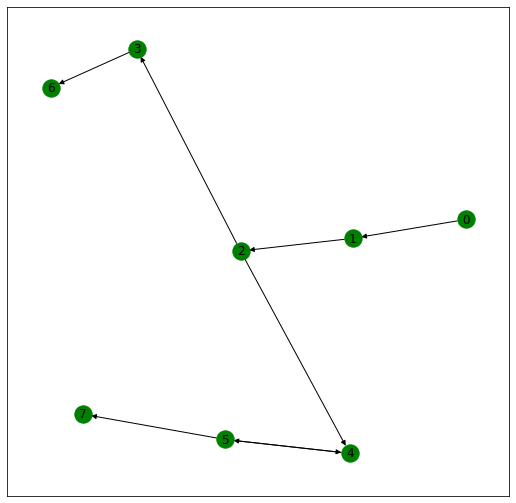

In [12]:
G = nx.DiGraph()
G.add_edges_from([(0, 1), (1, 2), (2, 3), (2, 4), (3, 6), 
                  (4, 5), (5, 4), (5, 7)])
  
plt.figure(figsize =(9, 9))

nx.draw_networkx(G, with_labels = True, node_color ='green')

**Esempio 2**

Stampa grafo

In [390]:
E = [i for i in range(0, 13)]    # Edges
V = []  # Vertex
w = [1 for i in range(0, 13)]  # Weigths
k = 3

In [391]:
V.append(Vertex(tp=Type.P, delta_in=[6, 4, 12], delta_out=[0])) # 0
V.append(Vertex(tp=Type.P, delta_in=[0], delta_out=[1])) # 1
V.append(Vertex(tp=Type.P, delta_in=[1], delta_out=[2, 12])) # 2
V.append(Vertex(tp=Type.P, delta_in=[5], delta_out=[6])) # 3
V.append(Vertex(tp=Type.P, delta_in=[3], delta_out=[4, 5])) # 4
V.append(Vertex(tp=Type.P, delta_in=[2], delta_out=[3])) # 5
V.append(Vertex(tp=Type.B, delta_in=[7], delta_out=[])) # 6
V.append(Vertex(tp=Type.B, delta_in=[9], delta_out=[])) # 7
V.append(Vertex(tp=Type.P, delta_in=[8, 11], delta_out=[10])) # 8
V.append(Vertex(tp=Type.P, delta_in=[10], delta_out=[11])) # 9

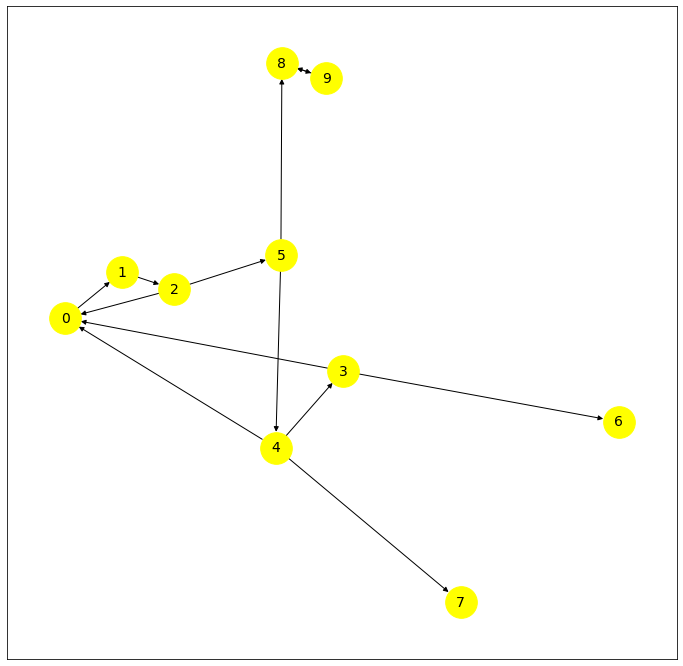

In [392]:
G = nx.DiGraph()
G.add_edges_from([(0, 1), (1, 2), (2, 5), (5, 4), (4, 0), (4, 3), (3, 0), 
                  (3, 6), (5, 8), (4, 7), (8, 9), (9, 8), (2, 0)])
  
plt.figure(figsize =(12, 12))

nx.draw_networkx(G, with_labels = True, node_color ='yellow', node_size = 1000, 
                 font_size = 14)

**Definizione modello**

In [419]:
# Model
model = Model('KEP_model')

# Decision variables
y = model.binary_var_dict(E, name='y')
f_in = model.continuous_var_dict(len(V), name='f_in')
f_out = model.continuous_var_dict(len(V), name='f_out')

In [420]:
#Function to minimize
model.maximize(model.sum((w[e] * y[e]) for e in E))

In [421]:
#Constraints
model.add_constraints(model.sum(y[e] for e in V[v].delta_in) == f_in[v] for v,_ in enumerate(V))
model.add_constraints(model.sum(y[e] for e in V[v].delta_out) == f_out[v] for v,_ in enumerate(V))
model.add_constraints((f_out[v] <= f_in[v]) for v,_ in enumerate(V) if V[v].tp == Type.P)
model.add_constraints((f_in[v] <= 1) for v,_ in enumerate(V) if V[v].tp == Type.P)
model.add_constraints((f_out[v] <= 1) for v,_ in enumerate(V) if (V[v].tp == Type.AD or V[v].tp == Type.B))

[docplex.mp.LinearConstraint[](f_out_6,LE,1),
 docplex.mp.LinearConstraint[](f_out_7,LE,1)]

In [368]:
def get_cycles_edges(C, V):
  edges = []
  aux = []

  for c in C:
    aux = []
    
    for i,_ in enumerate(c):
      if (i + 1) != len(c):
        aux.append(list(set(V[c[i]].delta_out).intersection(set(V[c[i + 1]].delta_in)))[0])
      
      else:
        aux.append(list(set(V[c[i]].delta_out).intersection(set(V[c[0]].delta_in)))[0])
    
    edges.append(aux)

  return edges

In [422]:
all_cycles = list(nx.simple_cycles(G))
C = []

# Creiamo una lista di tutti i cicli con una lunghezza maggiore di k
for c in all_cycles:
  if len(c) > k:
    C.append(c)

C_edges = get_cycles_edges(C, V)

if len(C) > 0:
  # Aggiungiamo il lazy constraints al modello
  clb = model.register_callback(LazyCallback)
  clb.C = C_edges
  clb.y = y

**Soluzione**

In [423]:
solution = model.solve(log_output=True)
model.solve(log_output=True)

Version identifier: 20.1.0.1 | 2021-12-07 | 9dfdf6686
CPXPARAM_Read_DataCheck                          1
Legacy callback                                  LD
Lazy constraint(s) or lazy constraint/branch callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling presolve reductions that prevent crushing forms (CPX_PARAM_PREREFORM).
         Disabling repeat represolve because of lazy constraint/incumbent callback.
Tried aggregator 2 times.
MIP Presolve eliminated 14 rows and 4 columns.
Aggregator did 14 substitutions.
Reduced MIP has 10 rows, 15 columns, and 25 nonzeros.
Reduced MIP has 13 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.04 ticks)
Probing changed sense of 6 constraints.
Probing time = 0.00 sec. (0.01 ticks)
Clique table members: 28.
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. 

docplex.mp.solution.SolveSolution(obj=7,values={y_0:1,y_1:1,y_7:1,y_9:1,..

**Stampa soluzione**

In [424]:
print(solution)

solution for: KEP_model
objective: 7
y_0=1
y_1=1
y_7=1
y_9=1
y_10=1
y_11=1
y_12=1
f_in_0=1.000
f_in_1=1.000
f_in_2=1.000
f_in_6=1.000
f_in_7=1.000
f_in_8=1.000
f_in_9=1.000
f_out_0=1.000
f_out_1=1.000
f_out_2=1.000
f_out_8=1.000
f_out_9=1.000



In [426]:
edges = get_edges(solution.get_value_dict(y))
print(edges)

{0, 1, 7, 9, 10, 11, 12}


In [ ]:
chains, cycles = get_vertex(solution.get_value_dict(f_in), solution.get_value_dict(f_out), edges, V)

In [ ]:
for c in chains[0]:
  print(str(c.tp) + " " + str(c.delta_in) + " " + str(c.delta_out))

Type.AD [] [0]
Type.P [0] [1]
Type.P [1] [2]
Type.P [2] [4]
Type.B [4] []


In [ ]:
for c in cycles[0]:
  print(str(c.tp) + " " + str(c.delta_in) + " " + str(c.delta_out))

Type.P [5] [6]
Type.P [6] [5]
